# Deep Learning Optical Flow Estimation
## RAFT: Recurrent All-pairs Field Transforms for Optical Flow (ECCV 2020)

Zachary Teed and Jia Deng

**Original code**:

https://github.com/princeton-vl/RAFT

Torchvision implementation: https://pytorch.org/vision/main/models/raft.html

**Instructions**

Instruction figures are partially adapted from [jonassen li](https://youtu.be/r3ZtW30exoo)

**Citation**
```
@inproceedings{teed2020raft,
  title={Raft: Recurrent all-pairs field transforms for optical flow},
  author={Teed, Zachary and Deng, Jia},
  booktitle={Computer Vision--ECCV 2020: 16th European Conference, Glasgow, UK, August 23--28, 2020, Proceedings, Part II 16},
  pages={402--419},
  year={2020},
  organization={Springer}
}
```



# 1. Installation

In [1]:
!pip install av # 실행 후 세션을 다시 시작하여야 반영됩니다 (다시 시작한 후에는 셀 재실행하지 않습니다)

In [1]:
!wget http://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip
!unzip MPI-Sintel-complete.zip -d ./Sintel/

--2024-08-12 14:37:11--  http://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip
Resolving files.is.tue.mpg.de (files.is.tue.mpg.de)... 192.124.27.148
Connecting to files.is.tue.mpg.de (files.is.tue.mpg.de)|192.124.27.148|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip [following]
--2024-08-12 14:37:13--  https://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip
Connecting to files.is.tue.mpg.de (files.is.tue.mpg.de)|192.124.27.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5627783629 (5.2G) [application/zip]
Saving to: ‘MPI-Sintel-complete.zip’

MPI-Sintel-complete 100%[===================>]   5.24G  7.69MB/s    in 32m 8s  

2024-08-12 15:09:22 (2.78 MB/s) - ‘MPI-Sintel-complete.zip’ saved [5627783629/5627783629]

Archive:  MPI-Sintel-complete.zip
   creating: ./Sintel/bundler/
   creating: ./Sintel/bundler/win/
  inflating: ./Sintel/bundler/win/bundle

In [1]:
from pathlib import Path
import tempfile
from urllib.request import urlretrieve

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional

from torchvision.io import read_video
import torchvision.transforms.functional as F
from torchvision.transforms import ToTensor
from torchvision.datasets import KittiFlow, Sintel
from torchvision.models.optical_flow import Raft_Large_Weights
from torchvision.utils import flow_to_image, _log_api_usage_once
from torchvision.models.optical_flow.raft import ResidualBlock, FeatureEncoder, MotionEncoder, RecurrentBlock, FlowHead, UpdateBlock, MaskPredictor
from torchvision.models.optical_flow._utils import make_coords_grid, upsample_flow
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.instancenorm import InstanceNorm2d

In [2]:
# click this link to watch the video
video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"

In [3]:
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
_ = urlretrieve(video_url, video_path)
frames, _, _ = read_video(str(video_path), output_format="TCHW")

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [4]:
# pick two pairs of images for examples
img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

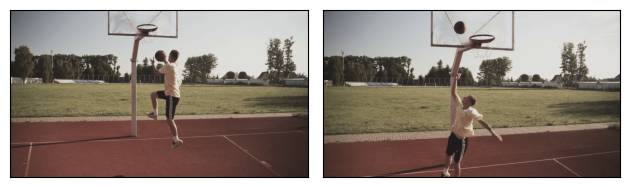

In [6]:
# visualize the images

plt.rcParams["savefig.bbox"] = "tight"

def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

plot(img1_batch)

# 2. Sintel Dataset

In [7]:
# transform the images
weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)

In [8]:
def sintel_transform(img1,img2,flow,mask):
    flow = torch.from_numpy(flow).to(device)
    trans = ToTensor()
    img1 = trans(img1)
    img1 = F.resize(img1, size=[432, 1024], antialias=False)
    img2 = trans(img2)
    img2 = F.resize(img2, size=[432, 1024], antialias=False)
    flow = F.resize(flow, size=[432, 1024], antialias=False)
    return img1, img2, flow, mask

In [9]:
img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

## MPI Sintel dataset

Synthetic dataset of 25 sequences with naturalistic effects

Dataset website: http://sintel.is.tue.mpg.de/

Example:

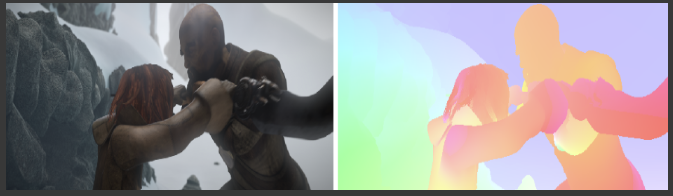

In [10]:
# dataset
trainset = Sintel(root='./',split='train',pass_name='final',transforms=sintel_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

# 3. Model

**Two different types of architectures**

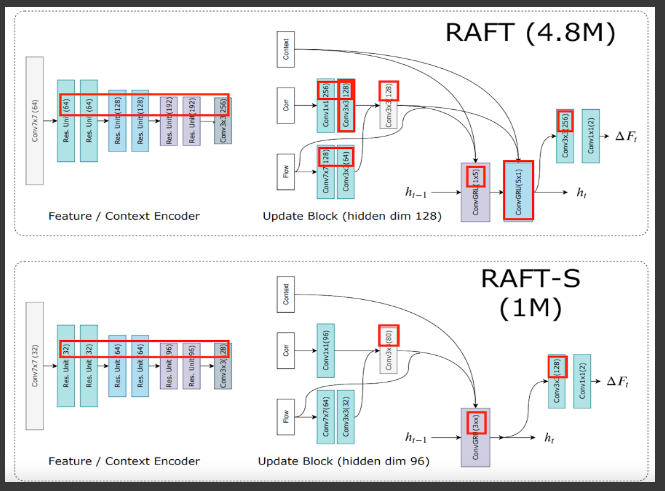

In [11]:
# load the model weights
weights=Raft_Large_Weights.DEFAULT
weights = Raft_Large_Weights.verify(weights)

In [12]:
class RAFT(nn.Module):
    def __init__(self, *, feature_encoder, context_encoder, corr_block, update_block, mask_predictor=None):
        super().__init__()
        _log_api_usage_once(self)

        self.feature_encoder = feature_encoder
        self.context_encoder = context_encoder
        self.corr_block = corr_block
        self.update_block = update_block

        self.mask_predictor = mask_predictor

        if not hasattr(self.update_block, "hidden_state_size"):
            raise ValueError("The update_block parameter should expose a 'hidden_state_size' attribute.")

    def forward(self, image1, image2, num_flow_updates: int = 12):

        batch_size, _, h, w = image1.shape
        if (h, w) != image2.shape[-2:]:
            raise ValueError(f"input images should have the same shape, instead got ({h}, {w}) != {image2.shape[-2:]}")
        if not (h % 8 == 0) and (w % 8 == 0):
            raise ValueError(f"input image H and W should be divisible by 8, instead got {h} (h) and {w} (w)")

        fmaps = self.feature_encoder(torch.cat([image1, image2], dim=0))
        fmap1, fmap2 = torch.chunk(fmaps, chunks=2, dim=0)
        if fmap1.shape[-2:] != (h // 8, w // 8):
            raise ValueError("The feature encoder should downsample H and W by 8")

        self.corr_block.build_pyramid(fmap1, fmap2) # 미리 계산

        ########### TODO: Check which images the context encoder was applied to in the paper, and implement it accordingly. #########
        context_out = self.context_encoder(image1)

        if context_out.shape[-2:] != (h // 8, w // 8):
            raise ValueError("The context encoder should downsample H and W by 8")

        hidden_state_size = self.update_block.hidden_state_size
        out_channels_context = context_out.shape[1] - hidden_state_size
        if out_channels_context <= 0:
            raise ValueError(
                f"The context encoder outputs {context_out.shape[1]} channels, but it should have at strictly more than hidden_state={hidden_state_size} channels"
            )
        hidden_state, context = torch.split(context_out, [hidden_state_size, out_channels_context], dim=1)
        hidden_state = torch.tanh(hidden_state)
        context = functional.relu(context)

        coords0 = make_coords_grid(batch_size, h // 8, w // 8).to(fmap1.device)
        coords1 = make_coords_grid(batch_size, h // 8, w // 8).to(fmap1.device)

        flow_predictions = []
        for _ in range(num_flow_updates):
            coords1 = coords1.detach()
            corr_features = self.corr_block.index_pyramid(centroids_coords=coords1)

            ############## TODO: Understand the content of the code above and create the flow tensor accordingly. ###########
            flow = coords1 - coords0
            hidden_state, delta_flow = self.update_block(hidden_state, context, corr_features, flow)

            ############### TODO: Update `coords1` ##################
            coords1 = coords1 + delta_flow

            up_mask = None if self.mask_predictor is None else self.mask_predictor(hidden_state)
            upsampled_flow = upsample_flow(flow=(coords1 - coords0), up_mask=up_mask)
            flow_predictions.append(upsampled_flow)

        return flow_predictions


## Feature Extraction
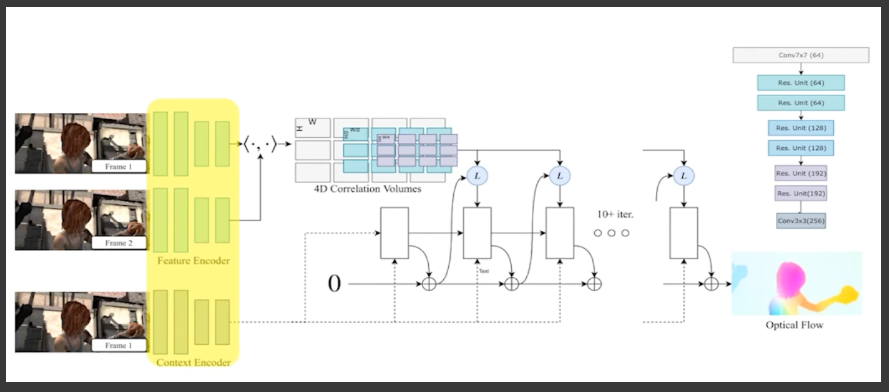

In [13]:
feature_encoder =FeatureEncoder(
    block=ResidualBlock, layers=(64, 64, 96, 128, 256), norm_layer=InstanceNorm2d
)
context_encoder = FeatureEncoder(
    block=ResidualBlock, layers=(64, 64, 96, 128, 256), norm_layer=BatchNorm2d
)

 ## Correlation Pyramid
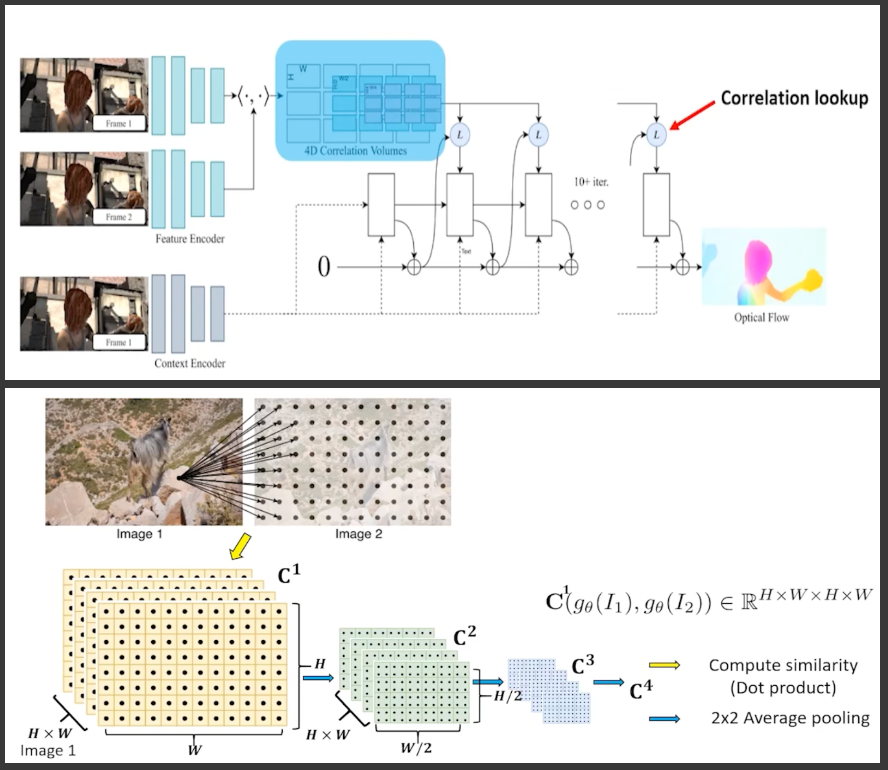

## Correlation Lookup
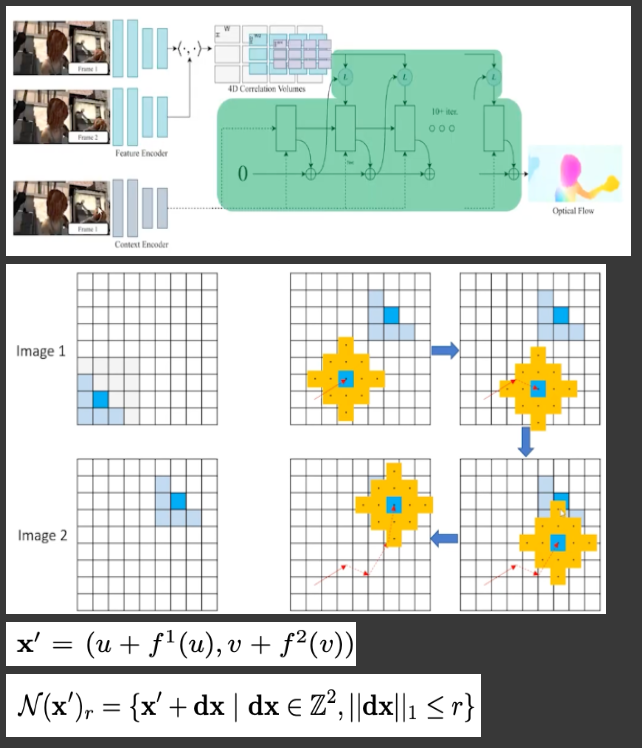

In [14]:
class CorrBlock(nn.Module):
    """The correlation block.

    Creates a correlation pyramid with ``num_levels`` levels from the outputs of the feature encoder,
    and then indexes from this pyramid to create correlation features.
    The "indexing" of a given centroid pixel x' is done by concatenating its surrounding neighbors that
    are within a ``radius``, according to the infinity norm (see paper section 3.2).
    Note: typo in the paper, it should be infinity norm, not 1-norm.
    """

    def __init__(self, *, num_levels: int = 4, radius: int = 4):
        super().__init__()
        self.num_levels = num_levels
        self.radius = radius

        self.corr_pyramid: List[Tensor] = [torch.tensor(0)]  # useless, but torchscript is otherwise confused :')
        self.out_channels = num_levels * (2 * radius + 1) ** 2

    def build_pyramid(self, fmap1, fmap2):
        """Build the correlation pyramid from two feature maps.

        The correlation volume is first computed as the dot product of each pair (pixel_in_fmap1, pixel_in_fmap2)
        The last 2 dimensions of the correlation volume are then pooled num_levels times at different resolutions
        to build the correlation pyramid.
        """

        # Explaining min_fmap_size below: the fmaps are down-sampled (num_levels - 1) times by a factor of 2.
        # The last corr_volume most have at least 2 values (hence the 2* factor), otherwise grid_sample() would
        # produce nans in its output.
        min_fmap_size = 2 * (2 ** (self.num_levels - 1))
        if any(fmap_size < min_fmap_size for fmap_size in fmap1.shape[-2:]):
            raise ValueError(
                "Feature maps are too small to be down-sampled by the correlation pyramid. "
                f"H and W of feature maps should be at least {min_fmap_size}; got: {fmap1.shape[-2:]}. "
                "Remember that input images to the model are downsampled by 8, so that means their "
                f"dimensions should be at least 8 * {min_fmap_size} = {8 * min_fmap_size}."
            )

        corr_volume = self._compute_corr_volume(fmap1, fmap2)

        batch_size, h, w, num_channels, _, _ = corr_volume.shape  # _, _ = h, w
        corr_volume = corr_volume.reshape(batch_size * h * w, num_channels, h, w)
        self.corr_pyramid = [corr_volume]

        ####### TODO: Check how to create the correlation pyramid and complete `self.corr_pyramid` #########
        ### Hint: Use `F.avg_pool2d` for Average Pooling ###
        for _ in range(self.num_levels - 1):
            corr_volume = functional.avg_pool2d(corr_volume, kernel_size=2, stride=2)
            self.corr_pyramid.append(corr_volume)

    def index_pyramid(self, centroids_coords):
        """Return correlation features by indexing from the pyramid."""
        neighborhood_side_len = 2 * self.radius + 1  # see note in __init__ about out_channels
        di = torch.linspace(-self.radius, self.radius, neighborhood_side_len)
        dj = torch.linspace(-self.radius, self.radius, neighborhood_side_len)
        delta = torch.stack(torch.meshgrid(di, dj, indexing="ij"), dim=-1).to(centroids_coords.device)
        delta = delta.view(1, neighborhood_side_len, neighborhood_side_len, 2)

        batch_size, _, h, w = centroids_coords.shape  # _ = 2
        centroids_coords = centroids_coords.permute(0, 2, 3, 1).reshape(batch_size * h * w, 1, 1, 2)

        indexed_pyramid = []
        ## Iterate over the correlation volume (corr_volume) at each level of self.corr_pyramid, adding delta to the center coordinates (centroids_coords) to generate sampling coordinates (sampling_coords).
        for corr_volume in self.corr_pyramid:

            ####### TODO: Calculate sampling_coords to extract the indices within a radius of (2r+1) from the target center point #####
            sampling_coords = centroids_coords + delta

            indexed_corr_volume = functional.grid_sample(corr_volume, sampling_coords, align_corners=True, mode="bilinear").view(
                batch_size, h, w, -1
            )
            indexed_pyramid.append(indexed_corr_volume)
            centroids_coords = centroids_coords / 2

        corr_features = torch.cat(indexed_pyramid, dim=-1).permute(0, 3, 1, 2).contiguous()

        return corr_features

    def _compute_corr_volume(self, fmap1, fmap2):
        batch_size, num_channels, h, w = fmap1.shape
        fmap1 = fmap1.view(batch_size, num_channels, h * w)
        fmap2 = fmap2.view(batch_size, num_channels, h * w)

        ################### TODO: Review and implement the method for generating the Correlation Volume ##################
        corr = torch.matmul(fmap1.transpose(1,2), fmap2)
        corr = corr.view(batch_size, h,w,1,h,w)

        return corr / torch.sqrt(torch.tensor(num_channels))

corr_block = CorrBlock(num_levels=4, radius=4)

In [15]:
motion_encoder = MotionEncoder(
    in_channels_corr=corr_block.out_channels,
    corr_layers=(256, 192),
    flow_layers=(128, 64),
    out_channels=128,
)

out_channels_context = 256 - 128
recurrent_block = RecurrentBlock(
    input_size=motion_encoder.out_channels + out_channels_context,
    hidden_size=128,
    kernel_size=((1,5),(5,1)),
    padding=((0,2), (2,0)),
)

## Iterative Update

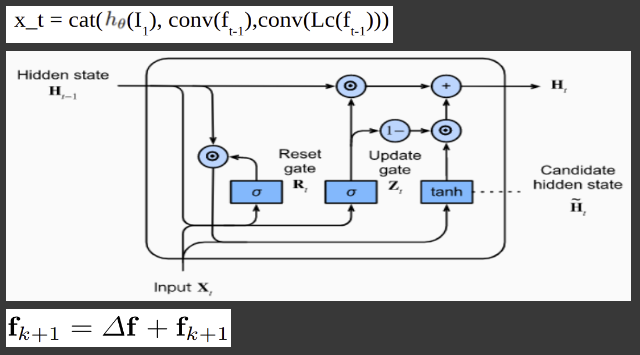

In [16]:
flow_head = FlowHead(in_channels=128, hidden_size=256)
update_block = UpdateBlock(motion_encoder=motion_encoder, recurrent_block=recurrent_block, flow_head=flow_head)

### Convex Upsampling
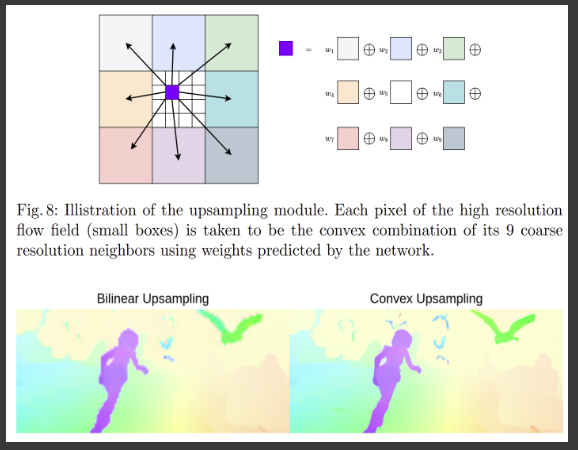

In [17]:
mask_predictor = MaskPredictor(
    in_channels=128,
    hidden_size=256,
    multiplier=0.25,
)

In [18]:
model = RAFT(
    feature_encoder=feature_encoder,
    context_encoder=context_encoder,
    corr_block=corr_block,
    update_block=update_block,
    mask_predictor=mask_predictor
)

if weights is not None:
    model.load_state_dict(weights.get_state_dict(progress=False))

model = model.to(device)

# 4. Training

In [19]:
# optimization arguments

lr=1e-9
optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=5e-4)
logging = 10
torch.manual_seed(3)

### Objective function

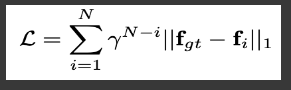

In [20]:
def sequence_loss(flow_list, flow_gt, gamma=0.7, weights=0.1):
    n_preds = len(flow_list)
    flow_loss = 0.0
    for i in range(n_preds):
        #### TODO: Review and implement the objective function formula ####
        i_weight = gamma ** (n_preds-i-1)
        i_loss = (flow_list[i] - flow_gt).abs()

        flow_loss += i_weight * i_loss.mean()

    return weights * flow_loss

In [21]:
model = model.train()

for batch_idx, (img1, img2, flow) in enumerate(trainloader):
    img1,img2, flow = img1.to(device),img2.to(device), flow.to(device)
    optimizer.zero_grad()
    output = model(img1,img2, num_flow_updates=12) # (B, 2, H, W). each entry corresponds to the horizontal and vertical displacement.
    loss = sequence_loss(output, flow)
    if batch_idx % logging == 0:
        print(f"iters: {batch_idx}/{len(trainloader)}, loss: {loss.item():.4f}")
    loss = loss.float()
    loss.backward()
    optimizer.step() # backpropagation

iters: 0/1041, loss: 4.1568
iters: 10/1041, loss: 0.6987
iters: 20/1041, loss: 10.9510
iters: 30/1041, loss: 0.9032
iters: 40/1041, loss: 2.1021
iters: 50/1041, loss: 2.4565
iters: 60/1041, loss: 3.7075
iters: 70/1041, loss: 1.5202
iters: 80/1041, loss: 1.4209
iters: 90/1041, loss: 7.0209
iters: 100/1041, loss: 1.4353
iters: 110/1041, loss: 1.1509
iters: 120/1041, loss: 1.9596
iters: 130/1041, loss: 4.7554
iters: 140/1041, loss: 2.3016
iters: 150/1041, loss: 3.2314
iters: 160/1041, loss: 8.5609
iters: 170/1041, loss: 0.5871
iters: 180/1041, loss: 0.5203
iters: 190/1041, loss: 1.2946
iters: 200/1041, loss: 5.5459
iters: 210/1041, loss: 1.1885
iters: 220/1041, loss: 0.6528
iters: 230/1041, loss: 8.6838
iters: 240/1041, loss: 0.9590
iters: 250/1041, loss: 0.8196
iters: 260/1041, loss: 0.9565
iters: 270/1041, loss: 5.6692
iters: 280/1041, loss: 7.0398
iters: 290/1041, loss: 5.1045
iters: 300/1041, loss: 3.8542
iters: 310/1041, loss: 0.7432
iters: 320/1041, loss: 4.3764
iters: 330/1041, los

# 5. Evaluation

In [22]:
model = model.eval()

In [23]:
list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

type = <class 'list'>
length = 12 = number of iterations of the model
dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -17.732067108154297, max = 9.3817720413208


### Visualization
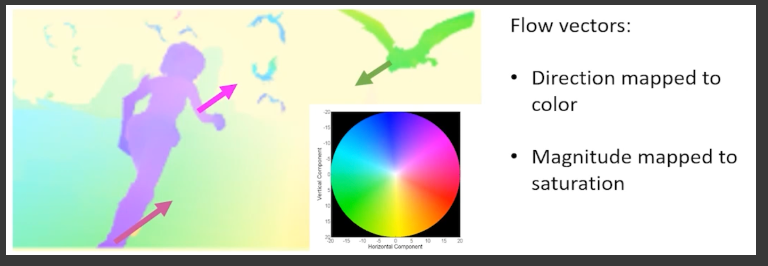

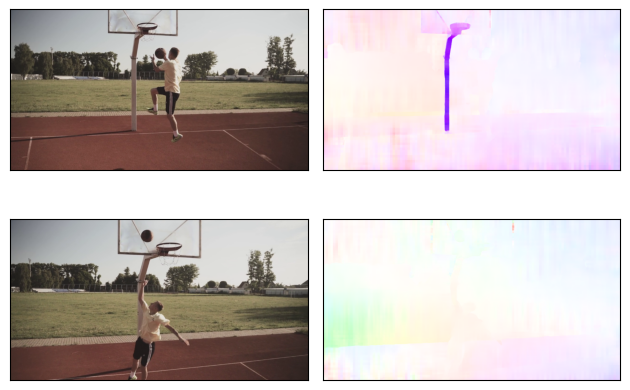

In [24]:
# visualize the results

flow_imgs = flow_to_image(predicted_flows) # supports batches of flows

img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

예상 결과:
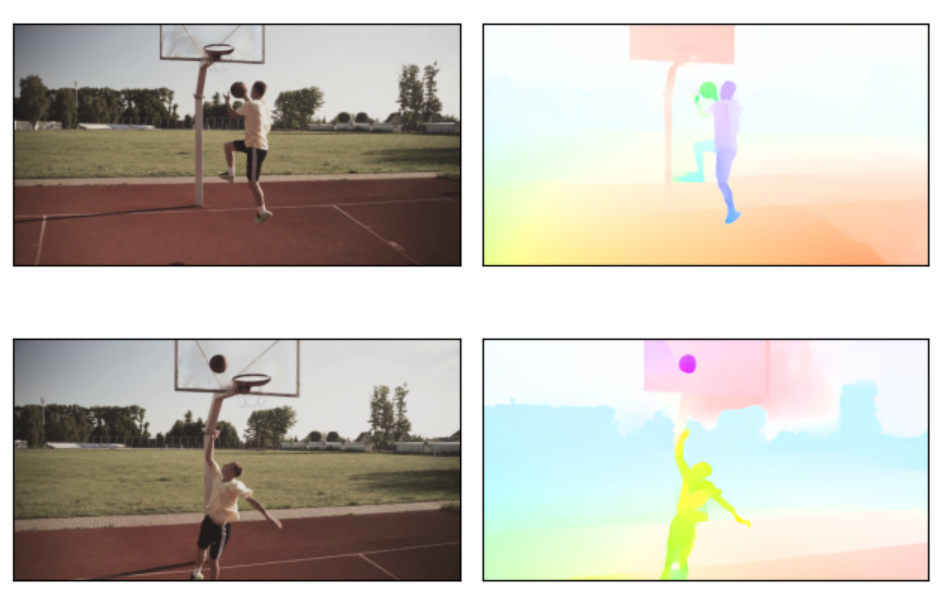